In [29]:

import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score



In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
image_size =(200,200)
batch_size= 32

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    './valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 120858 images belonging to 3 classes.
Found 2460 images belonging to 3 classes.
Found 2977 images belonging to 3 classes.


We define a custom AttentionLayer class that inherits from tf.keras.layers.Layer. This layer computes attention weights using a 1x1 convolutional layer and applies them to the input feature maps. The call method of the AttentionLayer computes attention weights by passing the input through a convolutional layer and then applies these weights to the input feature maps element-wise. The build_model function defines the CNN model architecture, incorporating the AttentionLayer after certain convolutional layers.
Finally, we compile the model and print its summary.


In [22]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')

    def call(self, inputs):
        # Compute attention weights
        attention_weights = self.conv(inputs)
        # Apply attention weights to input feature maps
        attended_inputs = inputs * attention_weights
        return attended_inputs
    
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Apply attention mechanism
    x = AttentionLayer()(x)
    
    # Flatten and add dense layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model





In [23]:
input_shape=(200, 200, 3)
num_classes = 3

In [24]:

def change_hyperparams(optimizer, epochs):
    model = build_model(input_shape, num_classes)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])          
    history = model.fit(train_generator, batch_size = batch_size, epochs=epochs, validation_data=val_generator,verbose=1)
    return model, history

In [31]:






def evaluate(model, history):
    # Evaluate on Validation data
    score = model.evaluate(val_generator)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1]*100)   

    # Generate predictions for the test dataset
    predictions = model.predict(test_generator)

    # Convert predictions to binary format
    predicted_labels = np.argmax(predictions, axis=1)

    # Retrieve ground truth labels from the test generator
    true_labels = test_generator.classes

    # Compute F1 score and precision
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')

    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')

    plt.plot(history.history['loss'], label='loss', color='red')
    plt.plot(history.history['val_loss'], label='val_loss', color='green')
    plt.legend()
    plt.title('Model 2')


3777/3777 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6961 - loss: 0.6632

/Users/rebecamonis/Downloads/Water_Road_CNN/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3777/3777 ━━━━━━━━━━━━━━━━━━━━ 1097s 290ms/step - accuracy: 0.6961 - loss: 0.6632 - val_accuracy: 0.6585 - val_loss: 0.7525
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6476 - loss: 0.7601
Test loss: 0.7522386312484741
Test accuracy: 65.85366129875183
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step
F1 Score: 0.4886453799383564
Precision: 0.6153503702741036


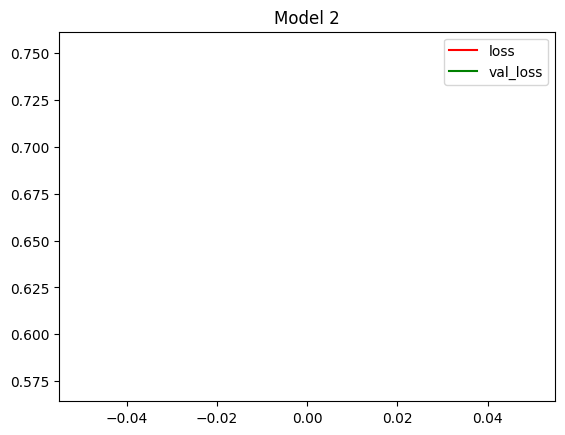

In [33]:
learning_rate = 0.001  # New learning rate value
epochs=25
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history=change_hyperparams(optimizer, epochs)

evaluate(model, history)

In [35]:
history.history

{'accuracy': [0.7367075681686401],
 'loss': [0.5732370615005493],
 'val_accuracy': [0.6585366129875183],
 'val_loss': [0.7524675726890564]}

In [ ]:
learning_rate = 0.001  # New learning rate value
epochs=50
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
change_hyperparams(optimizer, epochs)

In [ ]:
learning_rate = 0.01  # New learning rate value
epochs=25
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
change_hyperparams(optimizer, epochs)

In [ ]:
learning_rate = 0.01  # New learning rate value
epochs=25
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
change_hyperparams(optimizer, epochs)

In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
change_hyperparams(optimizer, epochs)

Epoch 1/25
  88/3777 ━━━━━━━━━━━━━━━━━━━━ 13:52 226ms/step - accuracy: 0.6316 - loss: 0.8706

KeyboardInterrupt: 

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')


 2/94 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.0000e+00 - loss: 1.7489  

/Users/rebecamonis/Downloads/Water_Road_CNN/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0026 - loss: 1.8406
Test accuracy: 0.003023177618160844
